importing dependencies

In [2]:
!pip install tensorflow-io[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 2.1 MB/s 
     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 438 kB 48.7 MB/s 
     |████████████████████████████████| 5.8 MB 46.6 MB/s 
     |████████████████████████████████| 1.6 MB 49.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as lbd

#butterworth
from scipy.signal import butter, sosfilt, sosfreqz

#frequency masking
import tensorflow_io as tfio

processed csv data

In [4]:
data_csv = pd.read_csv('/content/drive/MyDrive/hack/processed.csv')
data_csv.head()

,Unnamed: 0,start,end,pid,mode,filename,disease,crack_wheeze
0,0,1.862,5.718,160,mc,160_1b3_Al_mc_AKGC417L_0.wav,COPD,2
1,1,5.718,9.725,160,mc,160_1b3_Al_mc_AKGC417L_1.wav,COPD,3
2,2,9.725,13.614,160,mc,160_1b3_Al_mc_AKGC417L_2.wav,COPD,2
3,3,13.614,17.671,160,mc,160_1b3_Al_mc_AKGC417L_3.wav,COPD,2
4,4,17.671,19.541,160,mc,160_1b3_Al_mc_AKGC417L_4.wav,COPD,0


zero padded dataset

In [6]:
root = '/content/drive/MyDrive/hack/'
audio_root = root + 'processed_audio_files_7sec_22050/'

In [7]:
audio_file = ['102_1b1_Ar_sc_Meditron_10.wav', '107_2b3_Lr_mc_AKGC417L_4.wav', '110_1p1_Lr_sc_Meditron_2.wav']

In [8]:
sr=16000
zero_sound = []

for idx in range(len(audio_file)):
    audio = audio_root + audio_file[idx]
    sound, _ = lb.load(audio, sr=sr)
    zero_sound.append(sound)

butterworth

In [9]:
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [10]:
sr = 16000
butter_filtered = []

for idx in range(len(zero_sound)):
    filtered = butter_bandpass_filter(zero_sound[idx], 100, 2500, 16000, order=5)
    butter_filtered.append(filtered)

normalization

In [11]:
def normalization(x):
    return [2 * (num-np.min(x)) / (np.max(x) - np.min(x)) -1 for num in x]

In [12]:
filtered_normalized = []

for i in range(len(butter_filtered)):
    normal = normalization(butter_filtered[i])
    filtered_normalized.append(normal)

In [13]:
np.max(filtered_normalized[1])

1.0

In [23]:
os.makedirs('/content/drive/MyDrive/hack/preprocessing_test_np')

In [24]:
np.save('/content/drive/MyDrive/hack/preprocessing_test_np/filtered_normalized', filtered_normalized)

In [25]:
filtered_normalized_load = np.load('/content/drive/MyDrive/hack/preprocessing_test_np/filtered_normalized.npy')

In [31]:
len(filtered_normalized_load)

3

In [14]:
filtered_normalized = np.array(filtered_normalized)

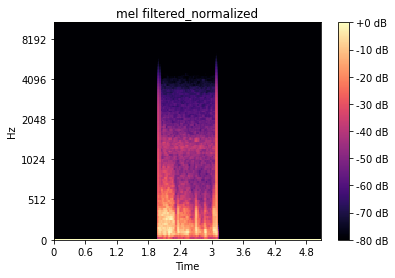

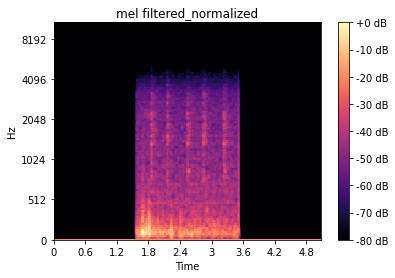

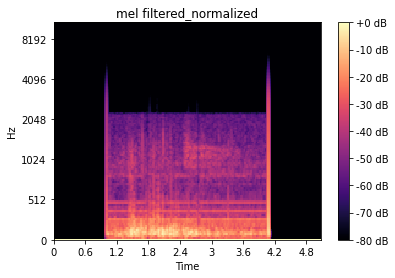

In [41]:
mSpec_list = []
for idx in range(len(filtered_normalized)):
    fig, ax = plt.subplots()
    M = lb.feature.melspectrogram(y=filtered_normalized[idx], sr=16000)
    M_db = lb.power_to_db(M, ref=np.max)
    mSpec_list.append(M_db)
    
    img = lbd.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
    ax.set(title='mel filtered_normalized')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    fig.savefig(f'./mSpec:{idx}')

Frequency Masking

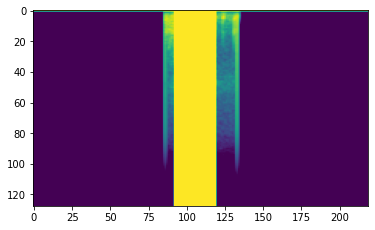

In [87]:
freq_m = tfio.audio.freq_mask(mSpec_list[0], param=30 )

plt.figure()
plt.imshow(freq_m.numpy())

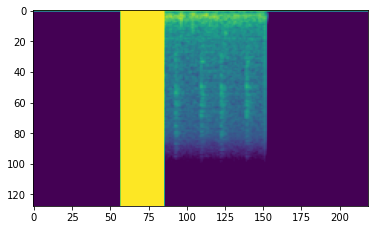

In [92]:
freq_m = tfio.audio.freq_mask(mSpec_list[1], param=60 )

plt.figure()
plt.imshow(freq_m.numpy())

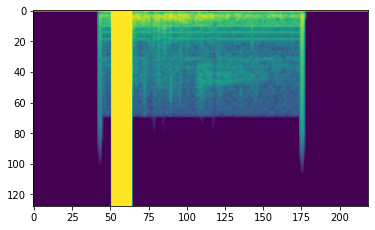

In [93]:
freq_m = tfio.audio.freq_mask(mSpec_list[2], param=30 )

plt.figure()
plt.imshow(freq_m.numpy())

# param 설정 방법?

이미지가 뒤집힌 이유?

time_stretch

In [94]:
def time_stretch(signal, stretch_rate):
    return lb.effects.time_stretch(signal, stretch_rate)

In [96]:
stretched = time_stretch(filtered_normalized[0], 0.5)

In [101]:
import soundfile as sf

sf.write('stretched.wav', stretched, sr)

In [103]:
import IPython.display as ipd
ipd.Audio('stretched.wav')

In [108]:
shortened = time_stretch(filtered_normalized[0], 1.5)
sf.write('shortened.wav', shortened, sr)

In [109]:
ipd.Audio('shortened.wav')

In [106]:
stretched

array([-0.35955665, -0.35955665, -0.35955665, ...,  0.01850512,
        0.01889653,  0.01928861])

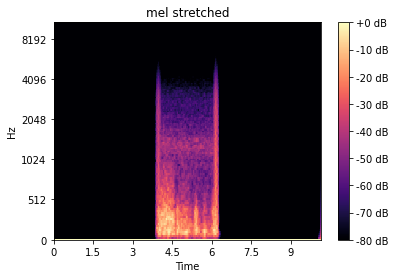

In [107]:
fig, ax = plt.subplots()
M = lb.feature.melspectrogram(y=stretched, sr=16000)
M_db = lb.power_to_db(M, ref=np.max)

img = lbd.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='mel stretched')
fig.colorbar(img, ax=ax, format="%+2.f dB")

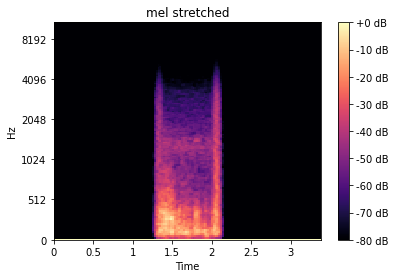

In [110]:
fig, ax = plt.subplots()
M = lb.feature.melspectrogram(y=shortened, sr=16000)
M_db = lb.power_to_db(M, ref=np.max)

img = lbd.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='mel stretched')
fig.colorbar(img, ax=ax, format="%+2.f dB")

pitch shift

In [111]:
def pitch_shift(signal, sr, num_semitones):
    return lb.effects.pitch_shift(signal, sr, num_semitones)

In [112]:
pitch_scaled = pitch_shift(filtered_normalized[0], sr, 2)
sf.write('pitch_scaled.wav', pitch_scaled, sr)

In [113]:
ipd.Audio('pitch_scaled.wav')

In [114]:
ipd.Audio('/content/drive/MyDrive/hack/processed_audio_files_7sec_22050/102_1b1_Ar_sc_Meditron_10.wav')

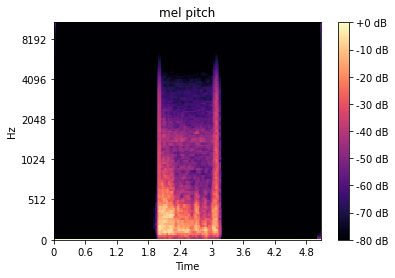

In [116]:
fig, ax = plt.subplots()
M = lb.feature.melspectrogram(y=pitch_scaled, sr=16000)
M_db = lb.power_to_db(M, ref=np.max)

img = lbd.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='mel pitch')
fig.colorbar(img, ax=ax, format="%+2.f dB")